In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['Root10DaysSeedling', 'Shoot10DaysSeedling', 'Root35DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot35DaysSeedling', 
                 'Root14DaysSeedling', 'Root24DaysSeedling', 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot21DaysSeedling', 'PCC', 'Shoot14DaysSeedling', 'Root52DaysSeedling', 'Shoot17DaysSeedling', 
                 'Leaf21DaysSeedling', 'log_2FoldChange', 'ET', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


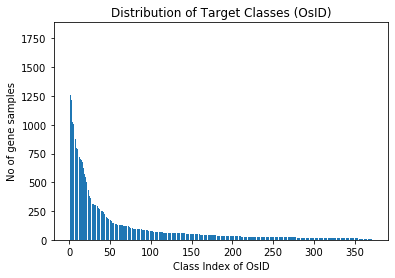

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=140, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/140
1846/1846 [==============================] - 4s 2ms/step - loss: 5.0118 - accuracy: 0.0412 - val_loss: 4.9046 - val_accuracy: 0.0750
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 4.3900 - accuracy: 0.1056 - val_loss: 4.1531 - val_accuracy: 0.1230
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.8467 - accuracy: 0.1548 - val_loss: 3.8133 - val_accuracy: 0.1802
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.5583 - accuracy: 0.2023 - val_loss: 3.5676 - val_accuracy: 0.2288
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3100 - accuracy: 0.2368 - val_loss: 3.3140 - val_accuracy: 0.2862
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0825 - accuracy: 0.2744 - val_loss: 3.1397 - val_accuracy: 0.2356
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9138 - accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 5.0287 - accuracy: 0.0410 - val_loss: 4.8605 - val_accuracy: 0.0647
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.4031 - accuracy: 0.1041 - val_loss: 4.2391 - val_accuracy: 0.1320
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8977 - accuracy: 0.1823 - val_loss: 3.6941 - val_accuracy: 0.2565
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.1106 - accuracy: 0.3661 - val_loss: 2.9341 - val_accuracy: 0.3670
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4763 - accuracy: 0.4659 - val_loss: 2.4924 - val_accuracy: 0.4964
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0910 - accuracy: 0.5245 - val_loss: 2.2432 - val_accuracy: 0.5138
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8550 - accuracy: 0.5545 - val_loss: 2.0616 - val_accuracy: 0.59

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 5.0349 - accuracy: 0.0389 - val_loss: 4.9127 - val_accuracy: 0.0647
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.5289 - accuracy: 0.0858 - val_loss: 4.3264 - val_accuracy: 0.1234
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.9380 - accuracy: 0.1536 - val_loss: 3.8611 - val_accuracy: 0.1793
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5573 - accuracy: 0.2059 - val_loss: 3.6148 - val_accuracy: 0.1740
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3243 - accuracy: 0.2290 - val_loss: 3.4721 - val_accuracy: 0.2365
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1506 - accuracy: 0.2430 - val_loss: 3.3463 - val_accuracy: 0.2425
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.9953 - accuracy: 0.2710 - val_loss: 3.2338 - val_accuracy: 0.25

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8483 - accuracy: 0.0602 - val_loss: 4.2970 - val_accuracy: 0.1274
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7134 - accuracy: 0.2530 - val_loss: 3.3326 - val_accuracy: 0.3395
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7625 - accuracy: 0.4356 - val_loss: 2.5916 - val_accuracy: 0.4649
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1350 - accuracy: 0.5449 - val_loss: 2.1702 - val_accuracy: 0.5705
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7179 - accuracy: 0.6167 - val_loss: 1.9237 - val_accuracy: 0.6279
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4385 - accuracy: 0.6674 - val_loss: 1.6850 - val_accuracy: 0.6662
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2677 - accuracy: 0.6920 - val_loss: 1.6029 - val_accuracy: 0.68

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.5670 - accuracy: 0.0826 - val_loss: 4.0729 - val_accuracy: 0.1353
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5330 - accuracy: 0.2769 - val_loss: 3.2374 - val_accuracy: 0.3615
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6063 - accuracy: 0.4605 - val_loss: 2.4900 - val_accuracy: 0.5355
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9491 - accuracy: 0.5661 - val_loss: 2.0235 - val_accuracy: 0.5527
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5539 - accuracy: 0.6410 - val_loss: 1.7437 - val_accuracy: 0.6847
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3039 - accuracy: 0.6830 - val_loss: 1.6042 - val_accuracy: 0.6933
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1586 - accuracy: 0.7055 - val_loss: 1.4747 - val_accuracy: 0.73

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7350 - accuracy: 0.0578 - val_loss: 4.2062 - val_accuracy: 0.0763
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6136 - accuracy: 0.2195 - val_loss: 3.2174 - val_accuracy: 0.3516
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.5906 - accuracy: 0.4615 - val_loss: 2.5061 - val_accuracy: 0.4847
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9349 - accuracy: 0.5705 - val_loss: 2.0539 - val_accuracy: 0.6207
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5542 - accuracy: 0.6480 - val_loss: 1.8074 - val_accuracy: 0.6543
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3337 - accuracy: 0.6818 - val_loss: 1.6383 - val_accuracy: 0.6708
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1894 - accuracy: 0.7057 - val_loss: 1.5327 - val_accuracy: 0.69

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.4697 - accuracy: 0.0978 - val_loss: 3.9359 - val_accuracy: 0.1551
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3998 - accuracy: 0.2431 - val_loss: 3.0906 - val_accuracy: 0.3435
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5634 - accuracy: 0.4700 - val_loss: 2.4491 - val_accuracy: 0.5505
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9736 - accuracy: 0.5851 - val_loss: 2.0043 - val_accuracy: 0.5879
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5660 - accuracy: 0.6468 - val_loss: 1.7051 - val_accuracy: 0.6389
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3094 - accuracy: 0.6859 - val_loss: 1.5371 - val_accuracy: 0.7149
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1470 - accuracy: 0.7132 - val_loss: 1.4831 - val_accuracy: 0.71

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7742 - accuracy: 0.0649 - val_loss: 4.2345 - val_accuracy: 0.1067
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7632 - accuracy: 0.1620 - val_loss: 3.5595 - val_accuracy: 0.2497
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0837 - accuracy: 0.3363 - val_loss: 2.9473 - val_accuracy: 0.4515
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4505 - accuracy: 0.5163 - val_loss: 2.4770 - val_accuracy: 0.5674
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.9833 - accuracy: 0.6007 - val_loss: 2.1923 - val_accuracy: 0.6147
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6532 - accuracy: 0.6576 - val_loss: 1.9340 - val_accuracy: 0.6678
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4041 - accuracy: 0.6995 - val_loss: 1.7475 - val_accuracy: 0.70

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.4880 - accuracy: 0.0877 - val_loss: 3.9836 - val_accuracy: 0.1393
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5487 - accuracy: 0.1938 - val_loss: 3.3826 - val_accuracy: 0.2330
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7345 - accuracy: 0.3974 - val_loss: 2.5078 - val_accuracy: 0.4750
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9341 - accuracy: 0.5799 - val_loss: 1.9481 - val_accuracy: 0.6110
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4955 - accuracy: 0.6509 - val_loss: 1.6553 - val_accuracy: 0.6898
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2354 - accuracy: 0.7073 - val_loss: 1.4795 - val_accuracy: 0.7063
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.0761 - accuracy: 0.7387 - val_loss: 1.3417 - val_accuracy: 0.74

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.5411 - accuracy: 0.0829 - val_loss: 4.0816 - val_accuracy: 0.1230
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6283 - accuracy: 0.1993 - val_loss: 3.3783 - val_accuracy: 0.3582
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7079 - accuracy: 0.4018 - val_loss: 2.6078 - val_accuracy: 0.4865
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0739 - accuracy: 0.5243 - val_loss: 2.1500 - val_accuracy: 0.5666
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6752 - accuracy: 0.6165 - val_loss: 1.8728 - val_accuracy: 0.6035
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4146 - accuracy: 0.6723 - val_loss: 1.7135 - val_accuracy: 0.6568
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2463 - accuracy: 0.6959 - val_loss: 1.5593 - val_accuracy: 0.70

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.4119 - accuracy: 0.0920 - val_loss: 3.8974 - val_accuracy: 0.1406
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4730 - accuracy: 0.2124 - val_loss: 3.2782 - val_accuracy: 0.2568
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7645 - accuracy: 0.3923 - val_loss: 2.6158 - val_accuracy: 0.4130
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1474 - accuracy: 0.5175 - val_loss: 2.1524 - val_accuracy: 0.5624
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7324 - accuracy: 0.6009 - val_loss: 1.8634 - val_accuracy: 0.6172
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4307 - accuracy: 0.6633 - val_loss: 1.6499 - val_accuracy: 0.6462
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.2422 - accuracy: 0.7034 - val_loss: 1.4833 - val_accuracy: 0.71

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.5908 - accuracy: 0.0839 - val_loss: 4.0888 - val_accuracy: 0.1485
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6991 - accuracy: 0.1816 - val_loss: 3.5758 - val_accuracy: 0.2418
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1289 - accuracy: 0.3110 - val_loss: 3.0291 - val_accuracy: 0.3822
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5988 - accuracy: 0.4267 - val_loss: 2.6117 - val_accuracy: 0.4504
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1913 - accuracy: 0.4976 - val_loss: 2.2793 - val_accuracy: 0.5318
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8826 - accuracy: 0.5600 - val_loss: 2.0816 - val_accuracy: 0.5791
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6355 - accuracy: 0.6138 - val_loss: 1.8995 - val_accuracy: 0.60

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.5998 - accuracy: 0.0894 - val_loss: 4.0656 - val_accuracy: 0.1534
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6024 - accuracy: 0.2016 - val_loss: 3.3795 - val_accuracy: 0.2515
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8571 - accuracy: 0.3944 - val_loss: 2.7403 - val_accuracy: 0.4504
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.3128 - accuracy: 0.4896 - val_loss: 2.3307 - val_accuracy: 0.5397
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9350 - accuracy: 0.5519 - val_loss: 2.0689 - val_accuracy: 0.5386
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6791 - accuracy: 0.5845 - val_loss: 1.8754 - val_accuracy: 0.5947
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4948 - accuracy: 0.6172 - val_loss: 1.6953 - val_accuracy: 0.64

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7168 - accuracy: 0.0647 - val_loss: 4.2706 - val_accuracy: 0.0882
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8862 - accuracy: 0.1538 - val_loss: 3.7607 - val_accuracy: 0.1718
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3226 - accuracy: 0.2822 - val_loss: 3.2234 - val_accuracy: 0.3342
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7740 - accuracy: 0.3972 - val_loss: 2.7926 - val_accuracy: 0.4477
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.3919 - accuracy: 0.4673 - val_loss: 2.5234 - val_accuracy: 0.4904
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1203 - accuracy: 0.5206 - val_loss: 2.3155 - val_accuracy: 0.5399
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9088 - accuracy: 0.5713 - val_loss: 2.1491 - val_accuracy: 0.56

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.5298 - accuracy: 0.0778 - val_loss: 4.0387 - val_accuracy: 0.1219
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7012 - accuracy: 0.1610 - val_loss: 3.6131 - val_accuracy: 0.1688
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2588 - accuracy: 0.2438 - val_loss: 3.1711 - val_accuracy: 0.3006
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6622 - accuracy: 0.4024 - val_loss: 2.4973 - val_accuracy: 0.4812
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.0943 - accuracy: 0.5092 - val_loss: 2.1377 - val_accuracy: 0.4994
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7525 - accuracy: 0.5790 - val_loss: 1.8162 - val_accuracy: 0.6079
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5341 - accuracy: 0.6193 - val_loss: 1.6461 - val_accuracy: 0.63

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.6902 - accuracy: 0.0692 - val_loss: 4.1964 - val_accuracy: 0.1197
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.8087 - accuracy: 0.1367 - val_loss: 3.7014 - val_accuracy: 0.1978
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3469 - accuracy: 0.2262 - val_loss: 3.3097 - val_accuracy: 0.2882
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8767 - accuracy: 0.3581 - val_loss: 2.8791 - val_accuracy: 0.3908
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4396 - accuracy: 0.4605 - val_loss: 2.5059 - val_accuracy: 0.4871
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1162 - accuracy: 0.5214 - val_loss: 2.2386 - val_accuracy: 0.5212
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8428 - accuracy: 0.5753 - val_loss: 2.0123 - val_accuracy: 0.58

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.9118 - accuracy: 0.0539 - val_loss: 4.3540 - val_accuracy: 0.0891
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.9065 - accuracy: 0.1659 - val_loss: 3.7011 - val_accuracy: 0.2073
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2606 - accuracy: 0.3139 - val_loss: 3.1466 - val_accuracy: 0.3641
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7135 - accuracy: 0.4229 - val_loss: 2.7343 - val_accuracy: 0.4590
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2946 - accuracy: 0.4979 - val_loss: 2.4126 - val_accuracy: 0.5100
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9956 - accuracy: 0.5356 - val_loss: 2.2342 - val_accuracy: 0.5362
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.7886 - accuracy: 0.5643 - val_loss: 2.0890 - val_accuracy: 0.55

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8188 - accuracy: 0.0598 - val_loss: 4.3910 - val_accuracy: 0.1056
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.9642 - accuracy: 0.1469 - val_loss: 3.8041 - val_accuracy: 0.1743
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5168 - accuracy: 0.1933 - val_loss: 3.4823 - val_accuracy: 0.1987
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1758 - accuracy: 0.2494 - val_loss: 3.1788 - val_accuracy: 0.2840
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7913 - accuracy: 0.3362 - val_loss: 2.7826 - val_accuracy: 0.3556
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4433 - accuracy: 0.4098 - val_loss: 2.5028 - val_accuracy: 0.4394
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.1791 - accuracy: 0.4719 - val_loss: 2.3383 - val_accuracy: 0.48

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7942 - accuracy: 0.0634 - val_loss: 4.3201 - val_accuracy: 0.0678
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.9476 - accuracy: 0.1437 - val_loss: 3.7913 - val_accuracy: 0.1756
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5147 - accuracy: 0.1974 - val_loss: 3.4934 - val_accuracy: 0.1980
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1822 - accuracy: 0.2475 - val_loss: 3.2060 - val_accuracy: 0.2702
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8141 - accuracy: 0.3280 - val_loss: 2.8255 - val_accuracy: 0.3547
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4732 - accuracy: 0.4147 - val_loss: 2.5337 - val_accuracy: 0.4233
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2117 - accuracy: 0.4754 - val_loss: 2.3442 - val_accuracy: 0.47

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8014 - accuracy: 0.0677 - val_loss: 4.4662 - val_accuracy: 0.0807
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0443 - accuracy: 0.1394 - val_loss: 3.8518 - val_accuracy: 0.1641
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5776 - accuracy: 0.1870 - val_loss: 3.5516 - val_accuracy: 0.1817
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.2634 - accuracy: 0.2287 - val_loss: 3.2439 - val_accuracy: 0.2222
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9818 - accuracy: 0.2697 - val_loss: 3.0152 - val_accuracy: 0.2581
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7259 - accuracy: 0.3155 - val_loss: 2.7801 - val_accuracy: 0.3155
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.4989 - accuracy: 0.3604 - val_loss: 2.6433 - val_accuracy: 0.35

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

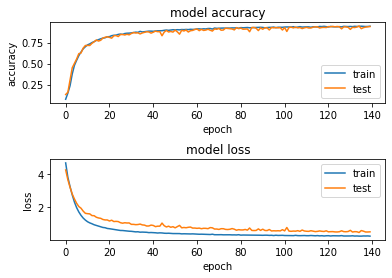

Final Test Accuracy: 0.9539323449134827


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       0.97      1.00      0.99       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os02g0655200         331              282       False
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.438
1,2,0.810
2,3,0.838
3,4,0.894
4,5,0.939
5,6,0.953
6,7,0.937
7,8,0.940
8,9,0.915
9,10,0.948
